In [1]:
import sys, argparse, os, multiprocessing.pool
from tqdm import tqdm

import pandas as pd
import numpy as np
import torch, librosa
import torch.nn as nn
import ffmpeg, torchaudio
from ffmpeg import Error

import math

import sys
sys.path.append('/root/mediazen/speech2blendshape')

from src.datasets import new_datamodule
from src.models.pl_model import SimpleFC
from src.utils import plot_spectrogram, plot_result

/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [5]:
device = 'cuda:1'

In [2]:
blendshape_columns = ['JawForward','JawOpen','MouthClose','MouthFunnel','MouthPucker','MouthDimpleLeft','MouthDimpleRight','MouthStretchLeft','MouthStretchRight','MouthRollLower','MouthRollUpper','MouthShrugLower','MouthShrugUpper','MouthPressLeft','MouthPressRight','CheekPuff']

In [3]:
dm = new_datamodule.GGongGGongDataModule(
    base_dir='/shared/air/shared/youngkim/mediazen',
    batch_size=2,
    num_workers=16,
    seed=1234,
    blendshape_columns=blendshape_columns,
    speakers=['jiha']
)

In [4]:
dm.prepare_data()
dm.setup()

In [6]:
for batch in dm.train_dataloader():
    break
x, x_length, y, y_length = batch
x = x.to(device)
x_length = x_length.to(device)
y = y.to(device)
y_length = y_length.to(device)

In [8]:
model = SimpleFC(
    csv_out_dir = '/shared/air/shared/youngkim/mediazen/csv_out',
    lr = 0.0001,
    deepspeech_model_path = '/shared/air/shared/youngkim/mediazen/pretrained/librispeech_pretrained_v2.pth',
    fc1_dim = 1024,
    fc2_dim = 1024,
    num_classes = 16,
    save_name = 'exp5',
)
model = model.load_from_checkpoint('/shared/air/shared/youngkim/mediazen/ckpt/exp5-24:10:15:46/epoch=92-step=2045.ckpt')
model.to(device)
None

In [9]:
enc_out, x_length = model.encoder(x, x_length, return_rnn_out=True)
enc_out = enc_out.permute(1, 2, 0).contiguous()
speech_features = model.interpolate_features(enc_out, x_length, y_length) # B, C, T
speech_features = speech_features.permute(0, 2, 1).contiguous() # B, T, C

/root/mediazen/speech2blendshape/src/models/full_deepspeech.py:251: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  seq_len = ((seq_len + 2 * m.padding[1] - m.dilation[1] * (m.kernel_size[1] - 1) - 1) // m.stride[1] + 1)


In [10]:
speech_features.shape

torch.Size([2, 2525, 1024])

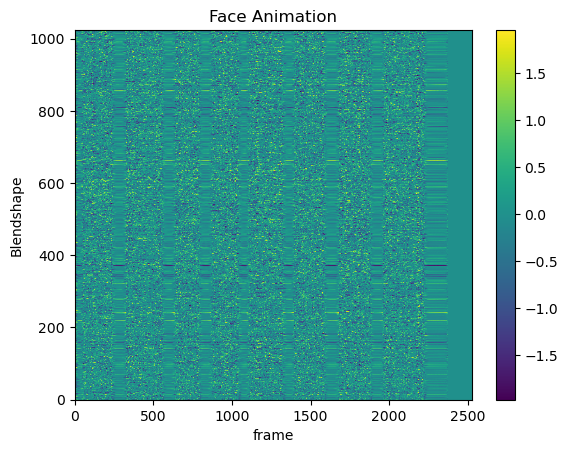

In [21]:
plot_result(speech_features[0].detach().cpu().T)

In [22]:
import torch.nn.functional as F

def attention_windowing(frame_fc_out):
    B, T, C = frame_fc_out.shape
    W = 8
    frame_fc_out = frame_fc_out.permute(0, 2, 1)
    padded_features = F.pad(frame_fc_out, (W//2-1, W//2))
    padded_features.permute(0, 2, 1)
    output_features = torch.zeros((B, T, C, W), device=frame_fc_out.device)

    for seq in range(T):
        windowed_features = padded_features[:,:,seq:seq+W].unsqueeze(1)
        output_features[:,seq:seq+1,:,:] = windowed_features

    return output_features

window_features = attention_windowing(speech_features)
window_features.shape

torch.Size([2, 2525, 1024, 8])

In [53]:
fully_connected = nn.Sequential(
            nn.AdaptiveAvgPool1d(1024), # -> 의미 없음
            nn.Linear(1024, 1024, bias=False),
            nn.LayerNorm(1024),
            nn.ReLU6(),
            nn.Dropout(0.2),
            nn.Linear(1024, 64, bias=False),
            nn.LayerNorm(64)
        )
attention_conv = nn.Sequential( # b x subspace_dim x seq_len
            nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(32, 16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(8, 4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(4, 1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True)
        )
attention = nn.Sequential(
    nn.Linear(8, 8, bias=True),   
    nn.Softmax(dim=1)
    )
fully_connected.to(device)
attention_conv.to(device)
attention.to(device)

Sequential(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): Softmax(dim=1)
)

In [54]:
speech_features.shape

torch.Size([2, 2525, 1024])

In [55]:
fc_out = fully_connected(speech_features)
fc_out.shape

torch.Size([2, 2525, 64])

In [56]:
windowed_fc_out = attention_windowing(fc_out)
windowed_fc_out.shape

torch.Size([2, 2525, 64, 8])

In [57]:
B, T, C, W = windowed_fc_out.shape
windowed_fc_out = windowed_fc_out.view(B*T, C, W) # B*T, 16, 8
att_conv_out = attention_conv(windowed_fc_out) # B*T, 1, 8
att_conv_out.shape

torch.Size([5050, 1, 8])

In [58]:
att_out = attention(att_conv_out) # B*T, 1, W
att_out = att_out.permute(0, 2, 1) # B*T, W, 1
att_out.shape

torch.Size([5050, 8, 1])

In [59]:
final_features = torch.bmm(windowed_fc_out, att_out) # B*T, C, 1
final_features = final_features.view(B, T, C)
final_features.shape

torch.Size([2, 2525, 64])